In [10]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import os
import time 
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = np.array(pd.read_csv("Datasets/digit-recognizer/train.csv"))
x_data, y_data = data[:, 1:data.shape[0]], data[:, 0:1]

indices = np.arange(len(x_data))
np.random.shuffle(indices)
x_data, y_data = x_data[indices], y_data[indices]

In [3]:
split = 0.9
idx = int(x_data.shape[0] * split)
trainx, trainy = x_data[:idx]/255., y_data[:idx]
x_validate, y_validate = x_data[idx:]/255., y_data[idx:]

In [4]:
trainy.shape

(37800, 1)

In [5]:
class NeuralNetwork:
    def __init__(self, layers: list(tuple())) -> None:
        """ Input as: 
            NeuralNetwork(
                [
                    ({no of features}, activation='{function}'), ---> input layer
                    ({neurons/nodes}, activation='{function}')
                    .
                    .
                    .
                    ({neurons/nodes}, activation='{function}') -----> output layer
                ]
            )"""
        np.random.seed(1024)
        
        self.layers = layers
        self.activationFunc = [a for _, (_, a) in enumerate(self.layers)]
        self.num_layers = len(self.layers)
        self.params = {}
        
        for l in range(1, self.num_layers):
            self.params[f'w{l}'] = np.random.rand(self.layers[l][0], self.layers[l-1][0]) - 0.5
            self.params[f'b{l}'] = np.random.rand(self.layers[l][0], 1) - 0.5
    
    def _activation(self, func: str, z, backprop=False):
        if func == 'relu':
            if backprop:
                return z > 0
            return np.maximum(0, z)
        
        elif func == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        
        elif func == 'softmax':
            exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
            return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def _loss(self, func, y_predicted, labels):
#         labels = OneHotEncoder().fit_transform(labels).toarray().T
        if func == 'cross_entropy':
            _, n = labels.shape
            epsilon = 1e-15
            y_predicted = np.maximum(epsilon, y_predicted)
            loss = -1/n * np.sum(labels * np.log(y_predicted))
            return loss
    
    def _forward_prop(self, x):
        z_a = {}
        for l in range(self.num_layers-1):
            if l == 0:
                z_a[f"z{l+1}"] = self.params[f"w{l+1}"].dot(x) + self.params[f"b{l+1}"]
                z_a[f"a{l+1}"] = self._activation(self.activationFunc[l+1], z_a[f"z{l+1}"])
            else:
                z_a[f"z{l+1}"] = self.params[f"w{l+1}"].dot(z_a[f"a{l}"]) + self.params[f"b{l+1}"]
                z_a[f"a{l+1}"] = self._activation(self.activationFunc[l+1], z_a[f"z{l+1}"])
        
        return z_a
    
    def _back_prop(self, zanda, x, y):
        m, _ = x.shape
        gradients = {}
        dz = {}
        dz_prev = None
        for l in reversed(range(1, self.num_layers)):
            if l == self.num_layers - 1:
                dA = zanda[f"a{self.num_layers-1}"] - y
                dZ = dA
                gradients[f"dw{l}"] = 1 / m * dZ.dot(zanda[f"a{l-1}"].T)
                gradients[f"db{l}"] = 1 / m * np.sum(dZ)
                dz_prev = dZ
            
            elif l > 1:
                w = self.params[f"w{l+1}"]
                dA = w.T.dot(dz_prev)
                dZ = dA * self._activation(self.activationFunc[l], zanda[f"z{l}"], backprop=True)
                gradients[f"dw{l}"] = 1 / m * dZ.dot(zanda[f"z{l-1}"].T)
                gradients[f"db{l}"] = 1 / m * np.sum(dZ)
                dz_prev = dZ
            
            elif l == 1:
                dA = self.params[f"w{l+1}"].T.dot(dz_prev)
                dZ = dA * self._activation(self.activationFunc[l], zanda[f"z{l}"], backprop=True)
                gradients[f"dw{l}"] = 1 / m * dZ.dot(x.T)
                gradients[f"db{l}"] = 1 / m * np.sum(dZ)

        return gradients
    
    
    def fit(self, x_train, y_train, learning_rate, lossFunction, validation_data=None, epochs=10, batch_size=32):
        """ Train the neural network based on training data.
            Input as: model.fit(
                            x_train, y_train, 
                            epoch=n, 
                            learning_rate=alpha, 
                            validation_data=(x, y), 
                            batch_size=32
                        )"""
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': []
        }
        
        m, n = x_train.shape
        num_classes = np.unique(y_train)
        y_train_encoded = OneHotEncoder().fit_transform(y_train).toarray()
        x_val = validation_data[0]
        y_val = validation_data[1]
        y_val_encoded = OneHotEncoder().fit_transform(y_val).toarray()
        sub_steps = m // batch_size
        
        for epoch in range(epochs):
            # --------------------------------------
            start_idx, end_idx = 0, batch_size
            print(f"\nEpoch {epoch+1}/{epochs}")
            indices = np.arange(len(x_train))
            np.random.shuffle(indices)
            x_train, y_train_encoded = x_train[indices], y_train_encoded[indices]
            y_train = y_train[indices]
            # -------------------------------------
            total_loss = 0
            total_samples = 0
            correct_predictions = 0
            for step in range(sub_steps+1):
                print(f"{step+1}/{sub_steps}", end="\r")
                # ------- transformations --------------------------------
                x, y = x_train[start_idx:end_idx].T, y_train_encoded[start_idx:end_idx].T
                yacc = y_train[start_idx:end_idx].T
                start_idx, end_idx = end_idx, end_idx+batch_size
                # --------------------------------------------------------
                # -------- training --------------------------------------
                za = self._forward_prop(x)
                gradients = self._back_prop(za, x, y)
                for params in self.params.keys():
                    self.params[params] -= learning_rate * gradients[f"d{params}"]
                # --------------------------------------------------------
                # ----------- loss and acc -------------------------------
                current_loss = self._loss(lossFunction, za[f"a{self.num_layers-1}"], y)
                current_prediction = self._get_predictions(za[f"a{self.num_layers-1}"])
                correct_predictions += np.sum(current_prediction == yacc)
                
                total_samples += yacc.size
                total_loss += current_loss
            
            train_loss = total_loss / sub_steps
            train_accuracy = correct_predictions / total_samples
            history["train_loss"].append(train_loss)
            history["train_accuracy"].append(train_accuracy)
            # ------------------------------------------------------------
            ## Calculating accuracy using validation data
            validate = self._forward_prop(x_val.T)
            accuracy = self.accuracy(validate[f"a{self.num_layers-1}"], y_val.T)
            loss = self._loss(lossFunction, validate[f"a{self.num_layers-1}"], y_val_encoded.T)
            
            history["val_loss"].append(loss)
            history["val_accuracy"].append(accuracy)
            
            # --------------- prints -------------------------------------
            print(f"{sub_steps}/{sub_steps}", end=" ")
            print(f"accuracy: {train_accuracy:2f} - loss: {train_loss:4f} - val_acc: {accuracy:2f} - val_loss: {loss:4f}")
            
        return history
            
    def accuracy(self, y_pred, y):
        predictions = self._get_predictions(y_pred)
        acc = np.sum(predictions == y) / y.size
#         print(f"pp {predictions.shape}, {y.shape}, {y.size}")
        return acc
        
    def _get_predictions(self, y_pred):
        return np.argmax(y_pred, axis=0)

    def summary(self):
        for i, (nodes, activation) in enumerate(self.layers):
            print(f"Layer {i}:\n\tNodes: {nodes} \n\tActivation: {activation}")
            

In [7]:
model = NeuralNetwork(
    [
        (784, 'relu'),
        (128, 'relu'),
        (64, 'relu'),
        (10, 'softmax')
    ]
)

history = model.fit(
    trainx, trainy, 
    epochs=10, 
    learning_rate=0.1,  
    lossFunction='cross_entropy',
    batch_size=32,
    validation_data = (x_validate, y_validate)
)


Epoch 1/10
1181/1181 accuracy: 0.596429 - loss: 1.562179 - val_acc: 0.759524 - val_loss: 0.768377

Epoch 2/10
1181/1181 accuracy: 0.791270 - loss: 0.684073 - val_acc: 0.820952 - val_loss: 0.572278

Epoch 3/10
1181/1181 accuracy: 0.833730 - loss: 0.553408 - val_acc: 0.849048 - val_loss: 0.489977

Epoch 4/10
1181/1181 accuracy: 0.853810 - loss: 0.485248 - val_acc: 0.868095 - val_loss: 0.439891

Epoch 5/10
1181/1181 accuracy: 0.867566 - loss: 0.440304 - val_acc: 0.878571 - val_loss: 0.404555

Epoch 6/10
1181/1181 accuracy: 0.877037 - loss: 0.408062 - val_acc: 0.885238 - val_loss: 0.380299

Epoch 7/10
1181/1181 accuracy: 0.885265 - loss: 0.383389 - val_acc: 0.890714 - val_loss: 0.361155

Epoch 8/10
1181/1181 accuracy: 0.892037 - loss: 0.362526 - val_acc: 0.895714 - val_loss: 0.342121

Epoch 9/10
1181/1181 accuracy: 0.896667 - loss: 0.345181 - val_acc: 0.899286 - val_loss: 0.329898

Epoch 10/10
1181/1181 accuracy: 0.901958 - loss: 0.330730 - val_acc: 0.903810 - val_loss: 0.317664


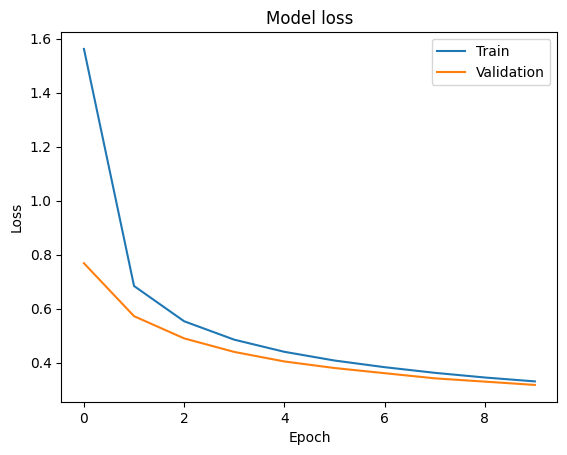

In [8]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

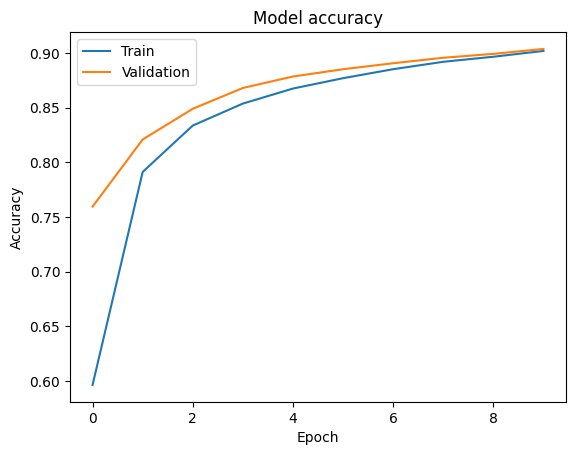

In [9]:
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()